In [23]:
#import qiskit tools
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise

#import python stuff
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
plt.rcParams['figure.figsize'] = [10, 6]
sns.set_theme()

In [9]:
# Set devices, if using a real device
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
quito = provider.get_backend('ibmq_quito')

sim = Aer.get_backend('aer_simulator')

In [11]:
def make_chsh_circuit(theta_vec):
    """Return a list of QuantumCircuits for use in a CHSH experiemnt
    (one for each value of theta in theta_vec)
    
        Args:
            theta_vec (list): list of values of angles between the bases of Alice and Bob
        
        Returns:
            List[QuantumCircuit]: CHSH QuantumCircuits for each value of theta
    """
    chsh_circuits = []
    
    for theta in theta_vec:
        obs_vec = ['00', '01', '10', '11']
        for el in obs_vec:
            qc = QuantumCircuit(2,2)
            qc.h(0)
            qc.cx(0, 1)
            qc.ry(theta, 0)
            for a in range(2):
                if el[a] == '1':
                    qc.h(a) 
            qc.measure(range(2),range(2))
            chsh_circuits.append(qc)

    return chsh_circuits

In [12]:
def compute_chsh_witness(counts):
    """Computes expectation values for the CHSH inequality, for each
    angle (theta) between measurement axis.

        Args: counts (list[dict]): dict of counts for each experiment
              (4 per value of theta)

        Returns:
            Tuple(List, List): Tuple of lists with the two CHSH witnesses
    """
    # Order is ZZ,ZX,XZ,XX
    
    CHSH1 = []
    CHSH2 = []
    # Divide the list of dictionaries in sets of 4
    for i in range(0, len(counts), 4):  
        theta_dict = counts[i:i + 4]
        zz = theta_dict[0]
        zx = theta_dict[1]
        xz = theta_dict[2]
        xx = theta_dict[3]

        no_shots = sum(xx[y] for y in xx)

        chsh1 = 0
        chsh2 = 0

        for element in zz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zz[element]
            chsh2+= parity*zz[element]

        for element in zx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zx[element]
            chsh2-= parity*zx[element]

        for element in xz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1-= parity*xz[element]
            chsh2+= parity*xz[element]

        for element in xx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*xx[element]
            chsh2+= parity*xx[element]

        CHSH1.append(chsh1/no_shots)
        CHSH2.append(chsh2/no_shots)
    
    return CHSH1, CHSH2

In [13]:
number_of_thetas = 15
theta_vec = np.linspace(0,2*np.pi,number_of_thetas)
my_chsh_circuits = make_chsh_circuit(theta_vec)

In [14]:
my_chsh_circuits[4].draw()

┌───┐     ┌─────────┐┌─┐
q_0: ┤ H ├──■──┤ Ry(π/7) ├┤M├
     └───┘┌─┴─┐└───┬─┬───┘└╥┘
q_1: ─────┤ X ├────┤M├─────╫─
          └───┘    └╥┘     ║ 
c: 2/═══════════════╩══════╩═
                    1      0

In [15]:
# Execute and get counts
result_ideal = sim.run(my_chsh_circuits).result()

tic = time.time()
transpiled_circuits = transpile(my_chsh_circuits, quito)
job_real = quito.run(transpiled_circuits, shots=8192)
job_monitor(job_real)
result_real = job_real.result()
toc = time.time()

print(toc-tic)

Job Status: job has successfully run
865.0575761795044


In [16]:
CHSH1_ideal, CHSH2_ideal = compute_chsh_witness(result_ideal.get_counts())
CHSH1_real, CHSH2_real = compute_chsh_witness(result_real.get_counts())

## Plot results

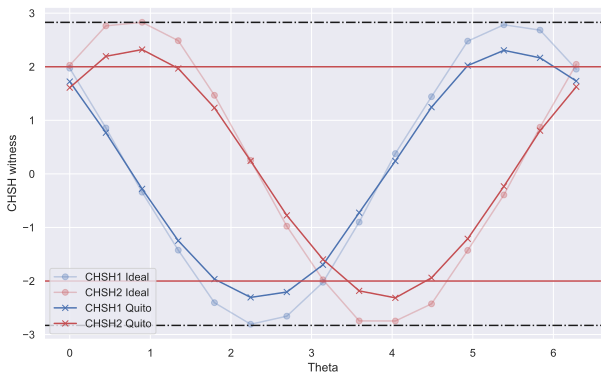

In [38]:
plt.plot(theta_vec,CHSH1_ideal,'o-', color='b', label = 'CHSH1 Ideal', alpha=0.3)
plt.plot(theta_vec,CHSH2_ideal,'o-', color='r',label = 'CHSH2 Ideal', alpha=0.3)

plt.plot(theta_vec,CHSH1_real,'x-', color='b', label = 'CHSH1 Quito')
plt.plot(theta_vec,CHSH2_real,'x-', color='r', label = 'CHSH2 Quito')


plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')
plt.show()